In [12]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_cv
import os
import IPython.display as display

In [13]:
dataset_location = '/mnt/c/Tugas Raihan/Kuliah/Matkul/Semester 6/Bangkit/Machine-Learning-Capstone/Food ingredient recognition.v4i.tfrecord'
tfrecord_name = "food-ingredient.tfrecord"
print(os.path.exists(dataset_location))

True


In [14]:
dataset_train = tf.data.TFRecordDataset(dataset_location + f"/train/{tfrecord_name}")

In [15]:
result = {}
for raw_record in dataset_train.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    for key, feature in example.features.feature.items():
        kind = feature.WhichOneof('kind')
        result[key] = np.array(getattr(feature, kind).value)

2024-05-30 12:33:04.476724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [16]:
for key, value in result.items():
    print(key, value)

image/object/bbox/ymin [0.25961539 0.28846154 0.32211539]
image/width [416]
image/object/bbox/xmax [0.34615386 0.70192307 0.99759614]
image/encoded [b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x01\xa0\x01\xa0\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92

In [17]:
feature_description = {
    'image/object/bbox/ymin' : tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmin' : tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymax' : tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmax' : tf.io.VarLenFeature(tf.float32),
    'image/object/class/text' : tf.io.VarLenFeature(tf.string),
    'image/object/class/label' : tf.io.VarLenFeature(tf.int64),
    'image/encoded' : tf.io.FixedLenFeature([], tf.string),
    'image/format' : tf.io.FixedLenFeature([], tf.string),
    'image/filename' : tf.io.FixedLenFeature([], tf.string),
    'image/height' : tf.io.FixedLenFeature([], tf.int64),
    'image/width' : tf.io.FixedLenFeature([], tf.int64)
}
def _parse_function(example_proto):
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    for key in ['image/object/bbox/ymin', 'image/object/bbox/xmin', 'image/object/bbox/ymax', 'image/object/bbox/xmax', 'image/object/class/text', 'image/object/class/label']:
        parsed_example[key] = tf.sparse.to_dense(parsed_example[key])
    return parsed_example

In [18]:
def preprocess_dataset(parsed_dataset):
    image = tf.image.decode_jpeg(parsed_dataset['image/encoded'])
    label = parsed_dataset['image/object/class/label']
    bounding_box = tf.stack([
        parsed_dataset['image/object/bbox/xmin'],
        parsed_dataset['image/object/bbox/ymin'],
        parsed_dataset['image/object/bbox/xmax'],
        parsed_dataset['image/object/bbox/ymax']
    ], axis=-1)
    image = tf.cast(image, tf.float32)
    return {
        'images': image,
        'bounding_boxes' : {
            'boxes': tf.cast(bounding_box, tf.float32),
            'classes': tf.cast(label, tf.int32)
        }
    }

def visualize_data(image, bounding_boxes):
    image = image.numpy()
    image = image.astype(np.uint8)
    colors = np.array([[1.0, 0.0, 0.0], [0.0, 0.0, 1.0]])
    tf.image.draw_bounding_boxes(image, tf.RaggedTensor.to_tensor(bounding_boxes['boxes'], shape=(None, 4)), colors=colors)
    plt.imshow(image)
    plt.show()
    

In [19]:
augmenter = tf.keras.Sequential([
    keras_cv.layers.RandomFlip(mode='horizontal', bounding_box_format="xyxy"),
    # keras_cv.layers.RandomRotation(factor=0.1, interpolation='bilinear', bounding_box_format="xyxy"),
    # keras_cv.layers.RandomTranslation(height_factor=0.1, width_factor=0.1, interpolation='bilinear', bounding_box_format="xyxy"),
    keras_cv.layers.RandomShear(x_factor=0.2, y_factor=0.2, interpolation='bilinear', bounding_box_format="xyxy"),
    # keras_cv.layers.JitteredResize(target_size=(240, 240), scale_factor=(0.8, 1.25), bounding_box_format="xyxy", interpolation='bilinear'),
    keras_cv.layers.Resizing(224, 224, bounding_box_format="xyxy", pad_to_aspect_ratio=True, interpolation='bilinear'),
])

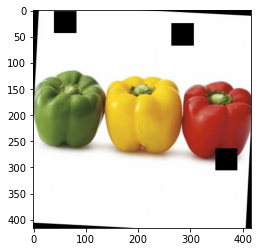

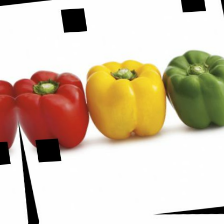

[]
<tf.RaggedTensor []>


2024-05-30 12:33:05.058803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [20]:
for parsed_dataset in dataset_train.map(_parse_function).map(preprocess_dataset).take(1):
    bounding_boxes = parsed_dataset['bounding_boxes']
    image = parsed_dataset['images']
    plt.imshow(image.numpy().astype(np.uint8))
    plt.show()
    res = augmenter(parsed_dataset)
    image_augmented = res["images"]
    display.display(tf.keras.preprocessing.image.array_to_img(image_augmented))
    print(res['bounding_boxes']['classes'].numpy())
    print(res['bounding_boxes']['boxes'])

In [21]:
dataset_train = dataset_train.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_train = dataset_train.map(preprocess_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)

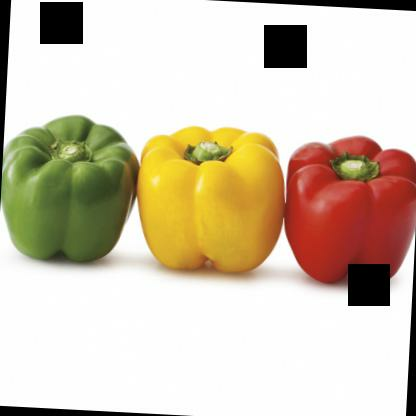

{'boxes': <tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0.        , 0.2596154 , 0.34615386, 0.65865386],
       [0.3125    , 0.28846154, 0.7019231 , 0.6730769 ],
       [0.68028843, 0.3221154 , 0.99759614, 0.7067308 ]], dtype=float32)>, 'classes': <tf.Tensor: shape=(3,), dtype=int32, numpy=array([6, 6, 6], dtype=int32)>}


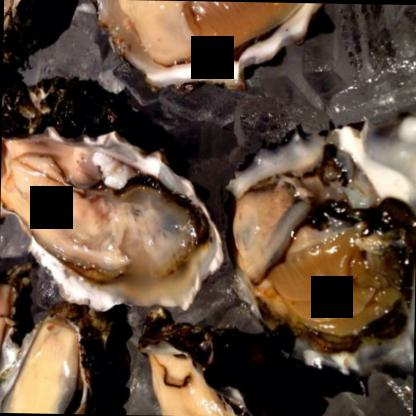

{'boxes': <tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.        , 0.29326922, 0.53846157, 0.75240386],
       [0.32932693, 0.78365386, 0.6682692 , 0.99759614],
       [0.5504808 , 0.29567307, 0.99759614, 0.8894231 ],
       [0.        , 0.74038464, 0.23798077, 0.9951923 ]], dtype=float32)>, 'classes': <tf.Tensor: shape=(4,), dtype=int32, numpy=array([26, 26, 26, 26], dtype=int32)>}


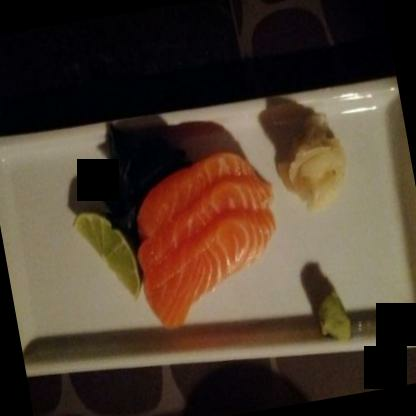

{'boxes': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.29807693, 0.3533654 , 0.68990386, 0.7860577 ]], dtype=float32)>, 'classes': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([31], dtype=int32)>}


2024-05-30 12:34:08.411647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [28]:
for image_features in dataset_train.take(3):
    display.display(tf.keras.preprocessing.image.array_to_img(image_features['images'].numpy()))
    print(image_features['bounding_boxes'])